<a href="https://colab.research.google.com/github/ChristianGoldbach/PINNs/blob/main/4_2_2D_heat_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code is based on one related to the article:

> Salvatore Cuomo, Vincenzo Schiano Di Cola, Fabio Giampaolo, Gianluigi Rozza,
Maziar Raissi, and Francesco Piccialli. Scientific machine learning through
physics-informed neural networks: Where we are and what's next. *Journal of
Scientific Computing,* 92(4):88, 2022.

You can find it here: https://github.com/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb


Additionally, it applies:
> Sokratis J. Anagnostopoulos, Juan Diego Toscano, Nikolaos Stergiopulos, and
George Em Karniadakis. Residual-based attention and connection to information
bottleneck theory in PINNs. *arXiv preprint arXiv:2307.00379,* 2023.

$$
\lambda^{k+1}_i = \gamma\lambda_i^k + \eta^*\frac{|r_\theta(t_i^r,\mathbf{x}_i^r)|}{\max_i(|r_\theta(t_i^r,\mathbf{x}_i^r)|)}
$$
Here, $\gamma$ and $\lambda$ are constants (e.g., $0.001$ and $0.999$).
The recursive factor is then integrated into the loss functional:
The parameters $\theta$ (weights, bias vectors) are dependent on the iteration $k$ (backpropagation).
$$
\phi_\theta^{r^*}(X^r) = \frac{1}{N_r}\sum_{i=1}^{N_r}\left\{(\lambda_i^{k+1}+c)r_\theta(t_i^r,\mathbf{x}_i^r)\right\}^,
$$
Here, $c$ is another parameter (e.g., 0.5).




In [ ]:
# Import necessary libraries: TensorFlow for machine learning,
# NumPy for numerical operations, and Matplotlib for visualization.
import tensorflow as tf
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [ ]:
# Set a random seed for TensorFlow to ensure reproducibility.
tf.random.set_seed(369)

# Define the dimensionality of the data.
dim = 2

# Set the data type to 'float32'.
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)
K = 100000

# Define a learning rate schedule using PiecewiseConstantDecay,
# with specified step boundaries and corresponding learning rates.
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([K/20,K/5,4*K/5],[0.0001, 0.0001, 0.0001, 0.0001])

# Create an Adam optimizer with the defined learning rate schedule.
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
import tensorflow as tf
tensorflow.__version__

'2.14.0'

In [ ]:
# Define a function fun_u_0 that computes a scalar field based on input vector x.
def fun_u_0(x):
    """
    Compute a scalar field u_0 using the exponential of the L2 norm of x.

    Args:
        x: Input vector.

    Returns:
        Scalar field u_0.
    """
    return tf.exp(-norm(x, axis=1, keepdims=True) * norm(x, axis=1, keepdims=True))#u(x,0)=u_0(x)=e^{-||x||^2}

# Define a function fun_u_b that computes a scalar field based on time t and input vector x.
def fun_u_b(t, x):
    """
    Compute a scalar field u_b using a summation of exponentials of L2 norms of x and t.

    Args:
        t: Time parameter.
        x: Input vector.

    Returns:
        Scalar field u_b.
    """
    return tf.reduce_sum(tf.exp(-norm(x, axis=1, keepdims=True) * norm(x, axis=1, keepdims=True) / (4 * (t + 1/4))) / (4 * (t + 1/4)), axis=1, keepdims=True)

# Define a function fun_r that computes a scalar field based on time t, input vector x, and partial derivatives of u.
def fun_r(t, x, u, u_t, u_x, u_xx):
    """
    Compute a scalar field r based on time t, input vector x, and partial derivatives of u.

    Args:
        t: Time parameter.
        x: Input vector.
        u: Scalar field u.
        u_t: Partial derivative of u with respect to time.
        u_x: Partial derivative of u with respect to x.
        u_xx: Second partial derivative of u with respect to x.

    Returns:
        Scalar field r.
    """
    return u_t - tf.reduce_sum(u_xx, axis=1, keepdims=True)

In [ ]:
# Define constants for the problem.
N_0 = 64 # Number of points for initialization.
N_b = 4*64  # Number of points for boundary conditions.
N_r = 64*64 # Number of points for the residual calculation.
tmin = 0  # Minimum time value.
tmax = 0.5  # Maximum time value (adjust this value as needed).
xmin = -1  # Minimum x (or y) value.
xmax = 1  # Maximum x (or y) value.

# Set lower and upper bounds for the problem.
lb = tf.constant([tmin, xmin, xmin], dtype=DTYPE)
ub = tf.constant([tmax, xmax, xmax], dtype=DTYPE)

In [ ]:
repeats = 64

# Generate initial data points for time and space.
t_0 = tf.ones((N_0, 1), dtype=DTYPE) * lb[0]
x_0 = tf.random.uniform((N_0, dim), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Generate boundary data points for time and space.
t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b, dim), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Generate residual data points for time and space.
t_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
t_r = tf.repeat(t_r, repeats=repeats, axis=0)
x_r = tf.random.uniform((N_r, dim), lb[1], ub[1], dtype=DTYPE)
x_r = tf.repeat(x_r, repeats=repeats, axis=0)
X_r = tf.concat([t_r, x_r], axis=1)  # Reorder to [x_r, t_r].

# Calculate the initial values u_0 at initial data points.
u_0 = fun_u_0(x_0)

# Calculate the boundary values u_b at boundary data points.
u_b = fun_u_b(t_b, x_b)

# Calculate the residual values u_r at residual data points.
u_r = fun_u_0(x_r)

# Organize the data into lists for convenience.
X_data = [X_0, X_b]
u_data = [u_0, u_b]

In [ ]:
# Function to initialize the neural network model.
def init_model(num_hidden_layers=4, num_neurons_per_layer=4):
    """
    Initialize a neural network model for solving a PDE.

    Args:
        num_hidden_layers: Number of hidden layers in the neural network.
        num_neurons_per_layer: Number of neurons in each hidden layer.

    Returns:
        Initialized neural network model.
    """
    lb = 0
    ub = 1

    # Define a scaling function for input data.
    def scaling_function(x):
        return 2.0 * (x - lb) / (ub - lb) - 1.0

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(dim + 1))
    scaling_layer = tf.keras.layers.Lambda(scaling_function)
    model.add(scaling_layer)

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
                                        activation=tf.keras.activations.get('tanh'), # Activation function
                                        kernel_initializer='glorot_normal'))

    model.add(tf.keras.layers.Dense(1))
    return model

# Function to calculate the residual values.
def get_r(model, X_r):
    """
    Calculate the residual values at residual data points.

    Args:
        model: Neural network model.
        X_r: Residual data points.

    Returns:
        Residual values.
    """
    with tf.GradientTape(persistent=True) as tape:
        t, x = X_r[:, 0:1], X_r[:, 1:]
        tape.watch(t)
        tape.watch(x)
        u = model(tf.concat([t, x], axis=1))
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
    del tape
    return fun_r(t, x, u, u_t, u_x, u_xx)

# Function to compute the loss for training the model. It includes the option of use the Residual-based attention strategy related above.
def compute_loss(model, X_r, X_data, u_data, h_a=1, k=2):
    """
    Compute the loss for training the model.

    Args:
        model: Neural network model.
        X_r: Residual data points.
        X_data: Data points (initial and boundary).
        u_data: Known data values.
        h_a: Hyperparameter for adjusting the loss function (optional).
        k: Hyperparameter for controlling the loss calculation (optional). If k!=2, then incorporating Residual-based attention strategy.

    Returns:
        Loss value.
    """
    if k != 2:
        save = get_r(model, X_r)
        h_values = 0.999 * h_a + 0.001 * (tf.abs(save) / tf.reduce_max(tf.abs(save)))
        r = (h_values + 0) * save
    else:
        r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    loss = phi_r

    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred)) #1

    if k != 2:
        h_a = h_values
        return loss, h_a

    return loss

# Function to calculate gradients and loss for model training.
def get_grad(model, X_r, X_data, u_data, h_a=1, k=2):
    """
    Calculate gradients and loss for model training.

    Args:
        model: Neural network model.
        X_r: Residual data points.
        X_data: Data points (initial and boundary).
        u_data: Known data values.
        h_a: Hyperparameter for adjusting the loss function (optional).
        k: Hyperparameter for controlling the loss calculation (optional).

    Returns:
        Loss value, gradients, and updated hyperparameter (if applicable).
    """
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(model.trainable_variables)
      if k!=2:
        h_a = compute_loss(model, X_r, X_data, u_data, h_a, k)[1]
        loss = compute_loss(model, X_r, X_data, u_data, h_a, k)[0]
      else:
        loss = compute_loss(model, X_r, X_data, u_data)
      g = tape.gradient(loss, model.trainable_variables)
    del tape
    if k != 2:
      return loss, g, h_a
    return loss, g

In [ ]:
# Initialize a neural network model with default parameters.
model = init_model()

In [ ]:
from time import time

# Define a training step as a TensorFlow function.
@tf.function
def train_step(eta=1,l=2):
    """
    Perform a training step for the neural network model.

    Args:
        h_a: Hyperparameter for adjusting the loss function (optional).
        k: Hyperparameter for controlling the loss calculation (optional).

    Returns:
        Loss value (and optionally, the updated hyperparameter).
    """
    if l!=2:
      loss, grad_theta, h_a = get_grad(model, X_r, X_data, u_data, h_a=eta, k=l) # Compute loss and gradients.
      optim.apply_gradients(zip(grad_theta, model.trainable_variables)) # Apply gradients to update the model.
    else:
      loss, grad_theta = get_grad(model, X_r, X_data, u_data, h_a=eta, k=l) #, h_a
      optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    if l != 2:
      return loss, h_a
    return loss

# Define the number of training iterations.
N = 100000

# Initialize an empty list to store loss history.
hist = []

# Record the start time of training.
t0 = time()

# Define the hyperparameter h for loss computation with the Residual-based attention strategy.
h = 2  # Modify this value as needed.
alpha = 1

# Loop over training iterations.
for i in range(N+1):
    if h!=2:
      loss, alpha = train_step(eta=alpha,l=h)
      hist.append(loss.numpy())
    else:
      loss = train_step(l=h) #, h_a
      hist.append(loss.numpy())

    # Print loss every 50 iterations.
    if i % 50 == 0:
        print('Iteration {:05d}: loss = {:10.8e}'.format(i, loss))

# Calculate and print the computation time.
print('\nComputation time: {} seconds'.format(time() - t0))

Iteration 00000: loss = 4.75268030e+00
Iteration 00050: loss = 4.16241264e+00
Iteration 00100: loss = 3.70183754e+00
Iteration 00150: loss = 3.32892227e+00
Iteration 00200: loss = 3.01728010e+00
Iteration 00250: loss = 2.75123501e+00
Iteration 00300: loss = 2.52028799e+00
Iteration 00350: loss = 2.31690812e+00
Iteration 00400: loss = 2.13548684e+00
Iteration 00450: loss = 1.97177160e+00
Iteration 00500: loss = 1.82251573e+00
Iteration 00550: loss = 1.68523335e+00
Iteration 00600: loss = 1.55802476e+00
Iteration 00650: loss = 1.43944180e+00
Iteration 00700: loss = 1.32838702e+00
Iteration 00750: loss = 1.22402894e+00
Iteration 00800: loss = 1.12574637e+00
Iteration 00850: loss = 1.03307450e+00
Iteration 00900: loss = 9.45677638e-01
Iteration 00950: loss = 8.63324106e-01
Iteration 01000: loss = 7.85880685e-01
Iteration 01050: loss = 7.13307917e-01
Iteration 01100: loss = 6.45658374e-01
Iteration 01150: loss = 5.83064497e-01
Iteration 01200: loss = 5.25707245e-01
Iteration 01250: loss = 4

In [ ]:
!python --version

Python 3.10.12


In [ ]:
# Import the ScalarFormatter class from the matplotlib.ticker module.
from matplotlib.ticker import ScalarFormatter

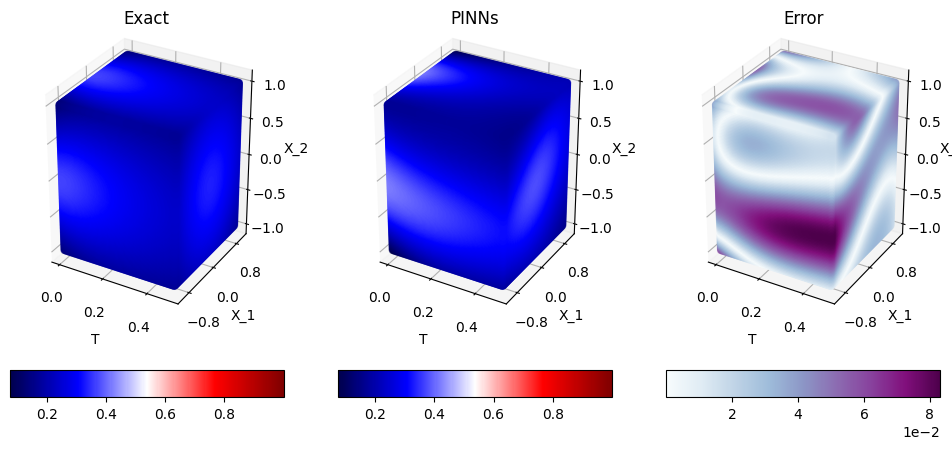

In [ ]:
# Define the spatial and temporal grid dimensions.
Nx = 100
Ny = 100
Nt = 100

# Create grids for spatial and temporal coordinates.
X = np.linspace(-1, 1, Nx)
Y = np.linspace(-1, 1, Ny)
T = np.linspace(0, 0.5, Nt)  # Adjust as needed
T2, X2, Y2 = np.meshgrid(T, X, Y, indexing='ij')
Xgrid = np.stack([T2, X2, Y2], axis=-1)
Xgrid_reshaped = Xgrid.reshape(-1, 3)

# Use the trained model to make predictions on the grid.
upred = model(tf.cast(Xgrid_reshaped, DTYPE))
U2 = upred.numpy().reshape(Nt, Nx, Nx)
PINNs = U2

# Convert grid data to TensorFlow tensors for the exact solution calculation.
T3 = tf.convert_to_tensor(Xgrid_reshaped[:, :1].reshape(-1, 1))
X3 = tf.convert_to_tensor(Xgrid_reshaped[:, 1:])
EXACT = fun_u_b(T3, X3)
EXACT = EXACT.numpy().reshape(Nt, Nx, Nx)

# Create a figure for 3D plots.
fig = plt.figure(figsize=(12, 8))
theta = 0.1
theta2 = 0.3

# Plot PINNs
ax1 = fig.add_subplot(132, projection='3d')
ax1.set_box_aspect([1, 1, 1 + theta2])
scatter1 = ax1.scatter(T2, X2, Y2, c=PINNs, cmap='seismic', vmin=min(EXACT.min(), PINNs.min()), vmax=max(EXACT.max(), PINNs.max()))
ax1.set_xlabel('T')
ax1.set_ylabel('X_1')
ax1.set_zlabel('X_2')
ax1.set_title('PINNs', y=1 + theta)

# Plot EXACT
ax2 = fig.add_subplot(131, projection='3d')
ax2.set_box_aspect([1, 1, 1 + theta2])
scatter2 = ax2.scatter(T2, X2, Y2, c=EXACT, cmap='seismic', vmin=min(EXACT.min(), PINNs.min()), vmax=max(EXACT.max(), PINNs.max()))
ax2.set_xlabel('T')
ax2.set_ylabel('X_1')
ax2.set_zlabel('X_2')
ax2.set_title('Exact', y=1 + theta)

# Add colorbar to both ax1 and ax2
cbar1 = fig.colorbar(scatter1, ax=ax1, location="bottom", aspect=10, pad=theta)
cbar2 = fig.colorbar(scatter2, ax=ax2, location="bottom", aspect=10, pad=theta)

# Plot Error
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_box_aspect([1, 1, 1 + theta2])
scatter3 = ax3.scatter(T2, X2, Y2, c=abs(EXACT - PINNs), cmap='BuPu')
ax3.set_xlabel('T')
ax3.set_ylabel('X_1')
ax3.set_zlabel('X_2')
ax3.set_title('Error', y=1 + theta)

# Add a colorbar for ax3
cbar3 = fig.colorbar(scatter3, ax=ax3, location="bottom", aspect=10, pad=theta)

# Configure scientific notation for axis labels.
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

# Configure scientific notation for colorbar labels.
cbar3.formatter.set_powerlimits((0, 0))

# Update colorbar ticks.
cbar1.update_ticks()
cbar2.update_ticks()
cbar3.update_ticks()

# Show the plot.
plt.show()

Text(0, 0.5, '$\\phi_{n_{epoch}}$')

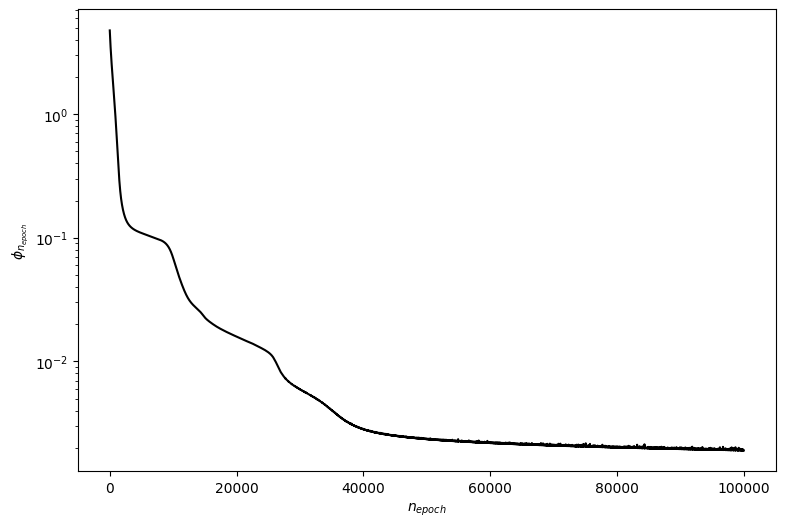

In [ ]:
# Create a figure for plotting the loss history.
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# Plot the loss values on a semilogarithmic scale.
ax.semilogy(range(len(hist)), hist, 'k-')

# Set the x-axis label and y-axis label.
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')

Text(0, 0.5, '$\\phi_{n_{epoch}}$')

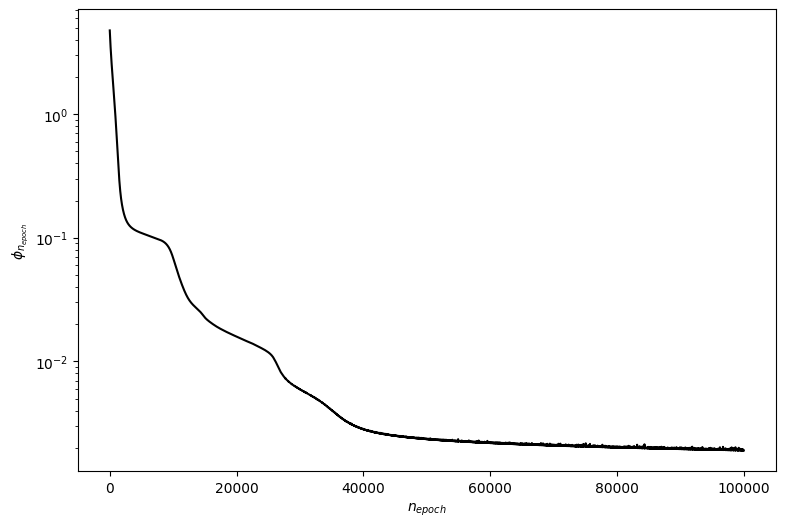

In [ ]:
# Create a figure for plotting the loss history.
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# Plot the loss values on a semilogarithmic scale.
ax.semilogy(range(len(hist)), hist, 'k-')

# Set the x-axis label and y-axis label.
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')

In [ ]:
# Calcula la diferencia entre las matrices Exact y PINNs
diferencia = EXACT - PINNs

# Calcula la norma L2 de la diferencia
error_absoluto = tf.norm(diferencia, ord='euclidean')

# Calcula la norma L2 de la matriz Exact
norma_exact = tf.norm(EXACT, ord='euclidean')

# Calcula el error relativo L2
error_relativo = error_absoluto / norma_exact

error_relativo

<tf.Tensor: shape=(), dtype=float64, numpy=0.07970620650913239>

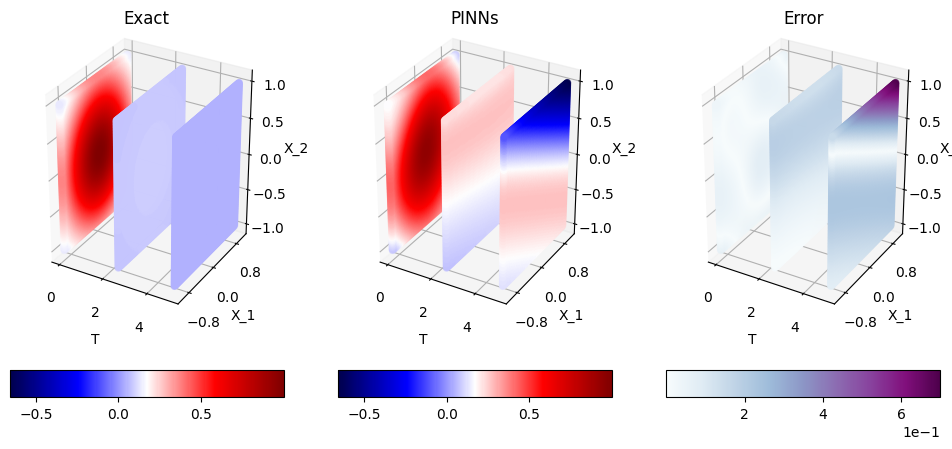

In [ ]:
# Define the spatial and temporal grid dimensions.
Nx = 100
Ny = 100
Nt = 3

# Create grids for spatial and temporal coordinates.
X = np.linspace(-1, 1, Nx)
Y = np.linspace(-1, 1, Ny)
T = np.linspace(0, 5, Nt)  # Adjust as needed
T2, X2, Y2 = np.meshgrid(T, X, Y, indexing='ij')
Xgrid = np.stack([T2, X2, Y2], axis=-1)
Xgrid_reshaped = Xgrid.reshape(-1, 3)

# Use the trained model to make predictions on the grid.
upred = model(tf.cast(Xgrid_reshaped, DTYPE))
U2 = upred.numpy().reshape(Nt, Nx, Nx)
PINNs = U2

# Convert grid data to TensorFlow tensors for the exact solution calculation.
T3 = tf.convert_to_tensor(Xgrid_reshaped[:, :1].reshape(-1, 1))
X3 = tf.convert_to_tensor(Xgrid_reshaped[:, 1:])
EXACT = fun_u_b(T3, X3)
EXACT = EXACT.numpy().reshape(Nt, Nx, Nx)

# Create a figure for 3D plots.
fig = plt.figure(figsize=(12, 8))
theta = 0.1
theta2 = 0.3

# Plot PINNs
ax1 = fig.add_subplot(132, projection='3d')
ax1.set_box_aspect([1, 1, 1 + theta2])
scatter1 = ax1.scatter(T2, X2, Y2, c=PINNs, cmap='seismic', vmin=min(EXACT.min(), PINNs.min()), vmax=max(EXACT.max(), PINNs.max()))
ax1.set_xlabel('T')
ax1.set_ylabel('X_1')
ax1.set_zlabel('X_2')
ax1.set_title('PINNs', y=1 + theta)

# Plot EXACT
ax2 = fig.add_subplot(131, projection='3d')
ax2.set_box_aspect([1, 1, 1 + theta2])
scatter2 = ax2.scatter(T2, X2, Y2, c=EXACT, cmap='seismic', vmin=min(EXACT.min(), PINNs.min()), vmax=max(EXACT.max(), PINNs.max()))
ax2.set_xlabel('T')
ax2.set_ylabel('X_1')
ax2.set_zlabel('X_2')
ax2.set_title('Exact', y=1 + theta)

# Add colorbar to both ax1 and ax2
cbar1 = fig.colorbar(scatter1, ax=ax1, location="bottom", aspect=10, pad=theta)
cbar2 = fig.colorbar(scatter2, ax=ax2, location="bottom", aspect=10, pad=theta)

# Plot Error
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_box_aspect([1, 1, 1 + theta2])
scatter3 = ax3.scatter(T2, X2, Y2, c=abs(EXACT - PINNs), cmap='BuPu')
ax3.set_xlabel('T')
ax3.set_ylabel('X_1')
ax3.set_zlabel('X_2')
ax3.set_title('Error', y=1 + theta)

# Add a colorbar for ax3
cbar3 = fig.colorbar(scatter3, ax=ax3, location="bottom", aspect=10, pad=theta)

# Configure scientific notation for axis labels.
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

# Configure scientific notation for colorbar labels.
cbar3.formatter.set_powerlimits((0, 0))

# Update colorbar ticks.
cbar1.update_ticks()
cbar2.update_ticks()
cbar3.update_ticks()

# Show the plot.
plt.show()

In [ ]:
# Calcula la diferencia entre las matrices Exact y PINNs
diferencia = EXACT - PINNs

# Calcula la norma L2 de la diferencia
error_absoluto = tf.norm(diferencia, ord='euclidean')

# Calcula la norma L2 de la matriz Exact
norma_exact = tf.norm(EXACT, ord='euclidean')

# Calcula el error relativo L2
error_relativo = error_absoluto / norma_exact

error_relativo

<tf.Tensor: shape=(), dtype=float64, numpy=0.4252142001659535>

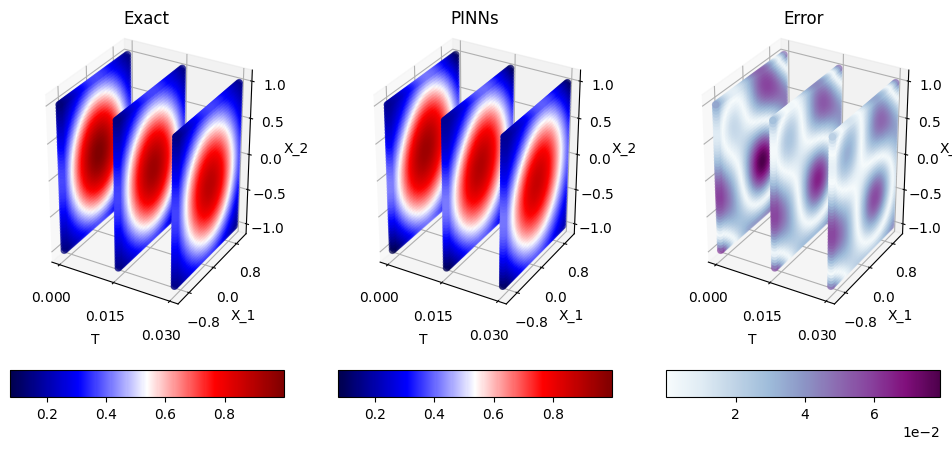

In [ ]:
# Define the spatial and temporal grid dimensions.
Nx = 50
Ny = 50
Nt = 3

# Create grids for spatial and temporal coordinates.
X = np.linspace(-1, 1, Nx)
Y = np.linspace(-1, 1, Ny)
T = np.linspace(0, 0.03, Nt)  # Adjust as needed
T2, X2, Y2 = np.meshgrid(T, X, Y, indexing='ij')
Xgrid = np.stack([T2, X2, Y2], axis=-1)
Xgrid_reshaped = Xgrid.reshape(-1, 3)

# Use the trained model to make predictions on the grid.
upred = model(tf.cast(Xgrid_reshaped, DTYPE))
U2 = upred.numpy().reshape(Nt, Nx, Nx)
PINNs = U2

# Convert grid data to TensorFlow tensors for the exact solution calculation.
T3 = tf.convert_to_tensor(Xgrid_reshaped[:, :1].reshape(-1, 1))
X3 = tf.convert_to_tensor(Xgrid_reshaped[:, 1:])
EXACT = fun_u_b(T3, X3)
EXACT = EXACT.numpy().reshape(Nt, Nx, Nx)

# Create a figure for 3D plots.
fig = plt.figure(figsize=(12, 8))
theta = 0.1
theta2 = 0.3

# Plot PINNs
ax1 = fig.add_subplot(132, projection='3d')
ax1.set_box_aspect([1, 1, 1 + theta2])
scatter1 = ax1.scatter(T2, X2, Y2, c=PINNs, cmap='seismic', vmin=min(EXACT.min(), PINNs.min()), vmax=max(EXACT.max(), PINNs.max()))
ax1.set_xlabel('T')
ax1.set_ylabel('X_1')
ax1.set_zlabel('X_2')
ax1.set_title('PINNs', y=1 + theta)

# Plot EXACT
ax2 = fig.add_subplot(131, projection='3d')
ax2.set_box_aspect([1, 1, 1 + theta2])
scatter2 = ax2.scatter(T2, X2, Y2, c=EXACT, cmap='seismic', vmin=min(EXACT.min(), PINNs.min()), vmax=max(EXACT.max(), PINNs.max()))
ax2.set_xlabel('T')
ax2.set_ylabel('X_1')
ax2.set_zlabel('X_2')
ax2.set_title('Exact', y=1 + theta)

# Add colorbar to both ax1 and ax2
cbar1 = fig.colorbar(scatter1, ax=ax1, location="bottom", aspect=10, pad=theta)
cbar2 = fig.colorbar(scatter2, ax=ax2, location="bottom", aspect=10, pad=theta)

# Plot Error
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_box_aspect([1, 1, 1 + theta2])
scatter3 = ax3.scatter(T2, X2, Y2, c=abs(EXACT - PINNs), cmap='BuPu')
ax3.set_xlabel('T')
ax3.set_ylabel('X_1')
ax3.set_zlabel('X_2')
ax3.set_title('Error', y=1 + theta)

# Add a colorbar for ax3
cbar3 = fig.colorbar(scatter3, ax=ax3, location="bottom", aspect=10, pad=theta)

# Configure scientific notation for axis labels.
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

# Configure scientific notation for colorbar labels.
cbar3.formatter.set_powerlimits((0, 0))

# Update colorbar ticks.
cbar1.update_ticks()
cbar2.update_ticks()
cbar3.update_ticks()

# Show the plot.
plt.show()

In [ ]:
# Calcula la diferencia entre las matrices Exact y PINNs
diferencia = EXACT - PINNs

# Calcula la norma L2 de la diferencia
error_absoluto = tf.norm(diferencia, ord='euclidean')

# Calcula la norma L2 de la matriz Exact
norma_exact = tf.norm(EXACT, ord='euclidean')

# Calcula el error relativo L2
error_relativo = error_absoluto / norma_exact

error_relativo

<tf.Tensor: shape=(), dtype=float64, numpy=0.053116217605876245>

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 3)                 0         
                                                                 
 dense_9 (Dense)             (None, 4)                 16        
                                                                 
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 4)                 20        
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (3